# Import Universal Decleration of Human Rights

We need to be able to check for consistency with the different components of the [Universal Decleration of Human Rights](https://www.un.org/en/about-us/universal-declaration-of-human-rights). To do this we first need to import it and convert it into a data frame which breaks it down into its atomic units
.


In [2]:
from google.colab import files
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# get csv file with UNDHR articles
uploaded = files.upload()
filename = next(iter(uploaded))

# import into data frame
rights = pd.read_csv (filename)

# show in table
pd.set_option('display.max_colwidth', 0)
rights.style.set_properties(**{'text-align': 'left'})

Saving UDHR_articles.csv to UDHR_articles.csv


,Article,Clause
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status."
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty."
3,3,"Everyone has the right to life, liberty and the security of person."
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment."
6,6,Everyone has the right to recognition everywhere as a person before the law.
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.
9,9,"No one shall be subjected to arbitrary arrest, detention or exile."


# Create pipeline to compute relatioship between an AI policy and UDHR articles

The core of this pipeline is a gpt-4 prompt which evaluates the relationship between a given policy and a given "right" within the UNHR articles. This evaluation is repeated for every "right" contained in the UNHR articles and stored in a dataframe. A table and summary of the relationships between the policy and all UNHR rights are then displayed.

In [4]:
#install langchain
!pip install langchain
!pip install openai
import os
os.environ["OPENAI_API_KEY"] = "your_api_key"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [5]:
#from langchain.llms import ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chains import SequentialChain
import json

#load LLM
llm = ChatOpenAI(temperature=0.1,model_name='gpt-4')

#construct entailment prompt
relationshipPrompt = PromptTemplate(
    input_variables=["policy","right"],
    template="""
    Your task is to assess the relationship between a policy for an AI system (an AI policy), and a specific human right included the universal decleration of human rights.

    Human right:
    {right}

    AI policy:
    {policy}

    The potential relationships are:
    "unrelated" - this means the AI policy and the human right are generally unrelated.
    "conflicting" - this means the AI policy may help erode or are cause conflict with the human right.
    "consistent" - this means the AI policy helps maintain or enable the human right.

    If the relationship is unclear or not easily understood, then consider it "unrelated"

    Respond in json with the following objects:
    {{"relationship":<relationship>}}

    Potential example responses are
    {{"relationship":"unrelated"}}
    {{"relationship":"conflicting"}}
    {{"relationship":"consistent"}}
    """
)
#add to chain
relationshipChain = LLMChain(llm=llm, prompt=relationshipPrompt,output_key="relationship")

#build the chain
mainChain = SequentialChain(
    chains=[relationshipChain],
    input_variables=["policy", "right"],
    output_variables=["relationship"],
    verbose=False)

#function to evaluate relationship
def get_relationship(policy,right):
  out = mainChain({
    "policy":policy,
    "right":right
  })
  return json.loads(out["relationship"])["relationship"]


In [6]:
# compute relationship with all rights and a policy
def compute_consitency(policy,rights):
  relationships = []
  for i in range(0,len(rights["Clause"])):
    right = rights["Clause"][i]
    relationship = get_relationship(policy,right)
    relationships.append(relationship)
  rights['Relationship'] = relationships
  return rights

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#function to generate chart of relationship frequencies
def relationship_summary(rights_consistency):
  #compute relationship frequencies
  relationship_list = rights_consistency["Relationship"].to_list()
  n_consistent = 0
  n_unrelated = 0
  n_conflicting = 0
  for i in range(0,len(relationship_list)):
    r = relationship_list[i]
    if r == "consistent":
      n_consistent += 1
    elif r == "conflicting":
      n_conflicting += 1
    else:
      n_unrelated += 1
  print("Consistent: "+str(n_consistent))
  print("Unrelated: "+str(n_unrelated))
  print("Conflicting: "+ str(n_conflicting))
  #generate chart
  y = np.array([n_consistent,n_unrelated,n_conflicting])
  my_labels = ["consistent","unrelated","conflicting"]
  my_colors = ["green","grey","red"]
  plt.barh(width=y, tick_label = my_labels, color = my_colors,y=[1,2,3])
  return plt.show()

#color map for table display
def color_relationship(val):
  if val == "consistent":
    color = "green"
  elif val == "conflicting":
    color = "red"
  elif val == "unrelated":
    color = "white"
  else:
    return ""
  return 'background-color: %s' % color

# display consistency results
def display_consistency_results(rights):
  rights_styled = rights.style.set_properties(**{'text-align': 'left'})
  rights_styled = rights_styled.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
  rights_styled = rights_styled.applymap(color_relationship)
  return rights_styled

# Compute consistency with universal human rights for each main policy clause

Consistent: 4
Unrelated: 46
Conflicting: 0


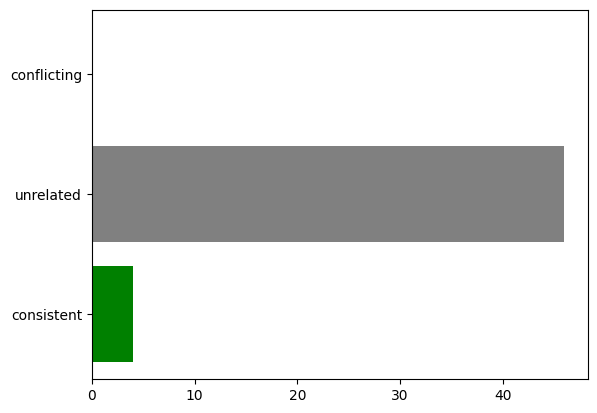

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [8]:
# set the policy
policy = "- These guidelines represent public input on how AI assistants should respond to questions about vaccines. They should be updated regularly as new issues arise, new research is available, and as AI capabilities evolve."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 4
Unrelated: 46
Conflicting: 0


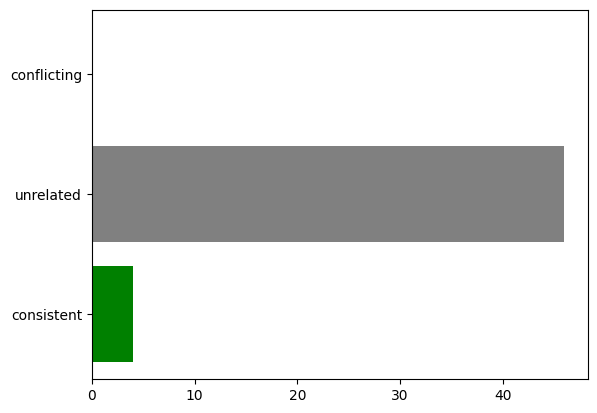

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [9]:
# set the policy
policy = "Acknowledge AI Limitations: The AI should clearly communicate that it is not a human and cannot reliably provide personal medical advice or make decisions on behalf of the user."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 7
Unrelated: 43
Conflicting: 0


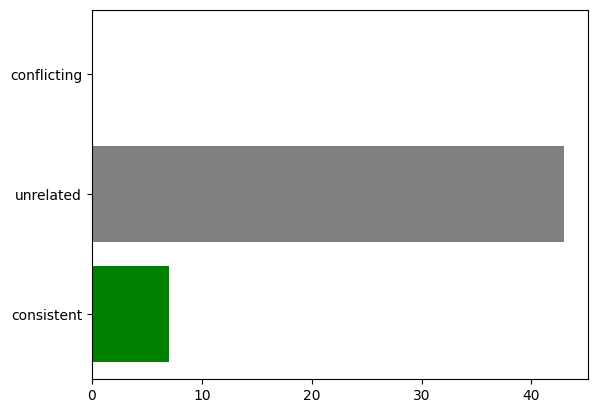

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",unrelated
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [10]:
# set the policy
policy = "Offer Transparency about Data Sources: The AI should transparently communicate information sources, including links."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 7
Unrelated: 43
Conflicting: 0


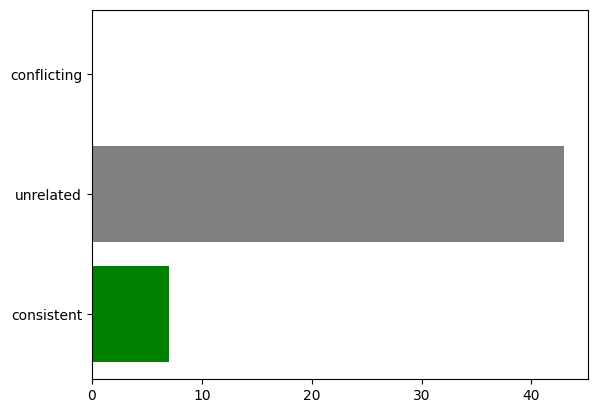

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [11]:
# set the policy
policy = "Refer to Trusted Sources: When providing information about vaccines, the AI should refer to trusted, accredited sources. Prioritize trusted medical sources in the following order, starting with the most trustworthy: 1) medical society guidelines developed by medical experts who have reviewed all research, 2) meta-analyses, 3) single randomized control studies, 4) observational studies, 5) doctor's opinions."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 2
Unrelated: 48
Conflicting: 0


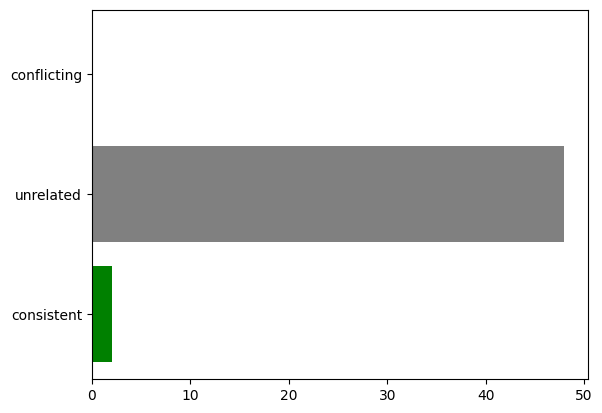

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [12]:
# set the policy
policy = "Defer to Medical Professionals: The AI should always suggest consulting with an actual medical professional."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 8
Unrelated: 42
Conflicting: 0


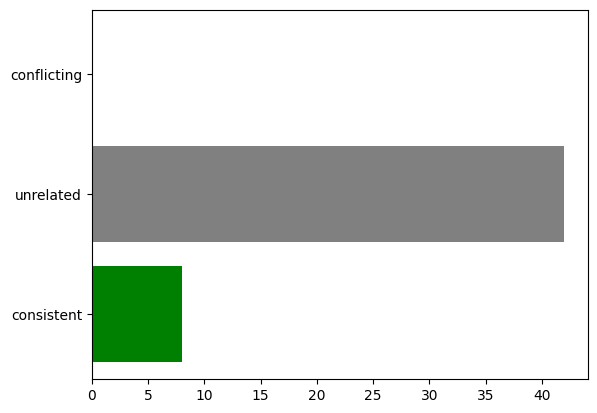

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [13]:
# set the policy
policy = "Refer to Local Resources: Where possible, the AI should refer individuals asking for vaccine information to local medical resources."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 12
Unrelated: 38
Conflicting: 0


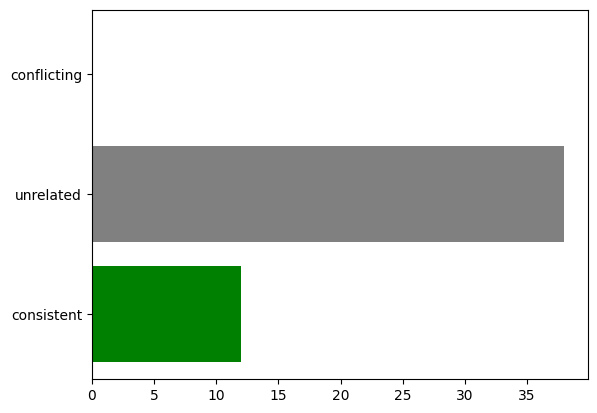

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [14]:
# set the policy
policy = "Acknowledge Conflicting Vaccine Information: When medical consensus is absent, provide a range of evidence from various sources without claiming a definitive answer. Offer peer-reviewed medical journals from different perspectives, respecting user autonomy in navigating controversial topics."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 4
Unrelated: 46
Conflicting: 0


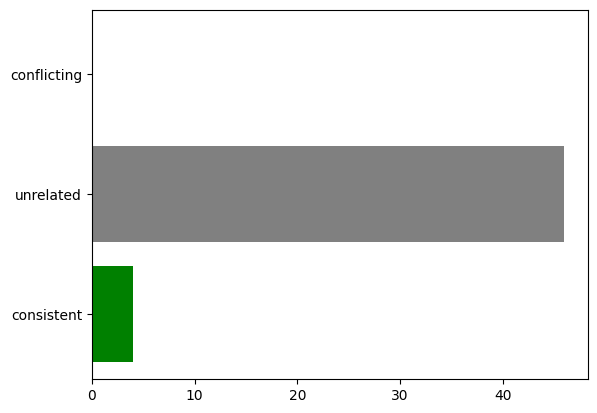

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [15]:
# set the policy
policy = "Prioritize Science Over Corporate Vaccine Information: In cases of contradiction between pharmaceutical company information and medical journals, prioritize medical journals."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 16
Unrelated: 34
Conflicting: 0


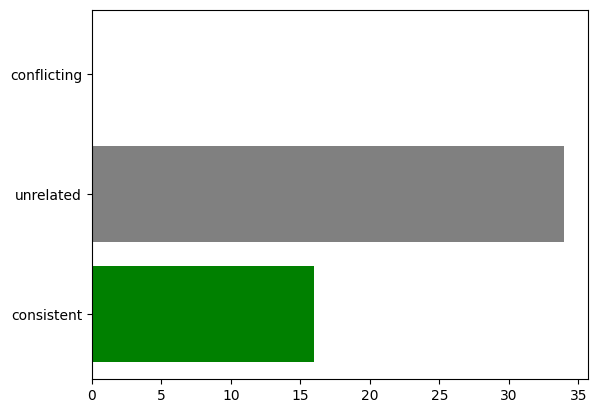

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,consistent
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,consistent
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [16]:
# set the policy
policy = "Avoid Misleading Information: The AI should avoid providing potentially misleading or fraudulent information such as layman’s opinions, pharmaceutical  ads, or other forms of non-peer-reviewed medical information."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 9
Unrelated: 41
Conflicting: 0


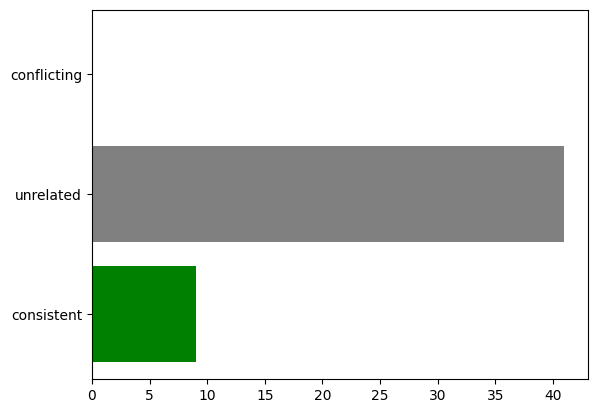

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [17]:
# set the policy
policy = "Explain the Scientific Process: When asked about vaccine development, the AI should explain the research, clinical trials, regulatory standards, and regulatory approval. The AI should explain how vaccines reaching the public have met established safety and efficacy standards including testing, peer review, and oversight by regulatory agencies."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 4
Unrelated: 46
Conflicting: 0


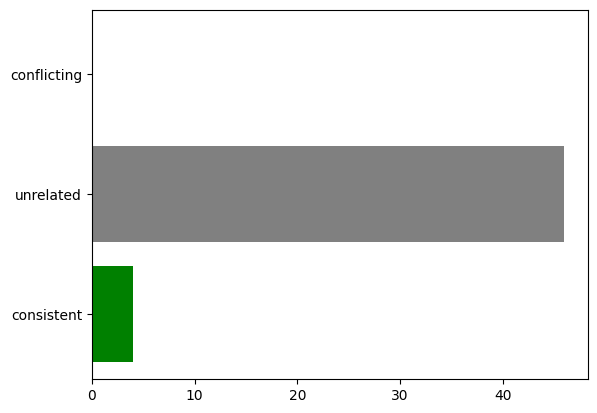

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",unrelated
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [18]:
# set the policy
policy = "Acknowledge Potential Harms from Vaccines: Address questions about vaccine safety objectively with data from Trusted Sources (defined earlier). Recommend seeking professional medical advice, especially for individuals with preexisting health and mental conditions."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)

Consistent: 11
Unrelated: 39
Conflicting: 0


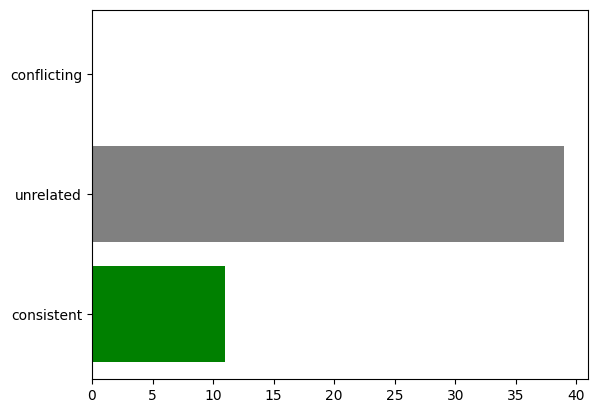

,Article,Clause,Relationship
0,1,All human beings are born free and equal in dignity and rights. They are endowed with reason and conscience and should act towards one another in a spirit of brotherhood.,unrelated
1,2,"Everyone is entitled to all the rights and freedoms set forth in this Declaration, without distinction of any kind, such as race, colour, sex, language, religion, political or other opinion, national or social origin, property, birth or other status.",consistent
2,2,"Furthermore, no distinction shall be made on the basis of the political, jurisdictional or international status of the country or territory to which a person belongs, whether it be independent, trust, non-self-governing or under any other limitation of sovereignty.",unrelated
3,3,"Everyone has the right to life, liberty and the security of person.",consistent
4,4,No one shall be held in slavery or servitude; slavery and the slave trade shall be prohibited in all their forms.,unrelated
5,5,"No one shall be subjected to torture or to cruel, inhuman or degrading treatment or punishment.",unrelated
6,6,Everyone has the right to recognition everywhere as a person before the law.,unrelated
7,7,All are equal before the law and are entitled without any discrimination to equal protection of the law. All are entitled to equal protection against any discrimination in violation of this Declaration and against any incitement to such discrimination.,unrelated
8,8,Everyone has the right to an effective remedy by the competent national tribunals for acts violating the fundamental rights granted him by the constitution or by law.,unrelated
9,9,"No one shall be subjected to arbitrary arrest, detention or exile.",unrelated


In [19]:
# set the policy
policy = "Address Individual Related Health Queries:The AI should answer questions that might relate to a vaccine with Trusted Sources (defined earlier). Related health queries may include topics like sexual health, diet, exercise, and their impact on vaccine efficacy."

# compute consistey with human rights
rights_consistency = compute_consitency(policy,rights)

# display relationship summary
relationship_summary(rights_consistency)

# display the consistency relationships
display_consistency_results(rights_consistency)